
# Milne-Eddington Inversions of a SIMULATED dataset


In [1]:
# Our good old packages for inversion, numerical manipulation and plotting...
import MilneEddington 
import numpy as np
import matplotlib.pyplot as plt

# You might remember this one, this allows us to load fits files into numpy arrays
from astropy.io import fits

In [2]:
#Load the data
stokes = fits.open('/home/milic/scratch/simulated_spectra.fits')[0].data
stokes.shape

(144, 144, 4, 301)

In [3]:
# Everything looks good (actually this is the same thing as the one we studied on the first day)
# We will normalize our data as before
# Mean over all the spatial points and the last 10 wavelengths
qs = np.mean(stokes[:,:,0,-10:])
stokes /= qs

In [4]:
# Let's also assign wavelengths.
# We are using the same equation as previously.
# Technically, if you decide to use a separate dataset, you should look up wavelength scaling in 
# the fits header (HINODE), or you should have it provded somewhere else. You can even do you own 
# wavelength calibration

ll = np.arange(301)*0.01+6300.5
#ll = 6302.08 + (ll-56.5)*0.0215

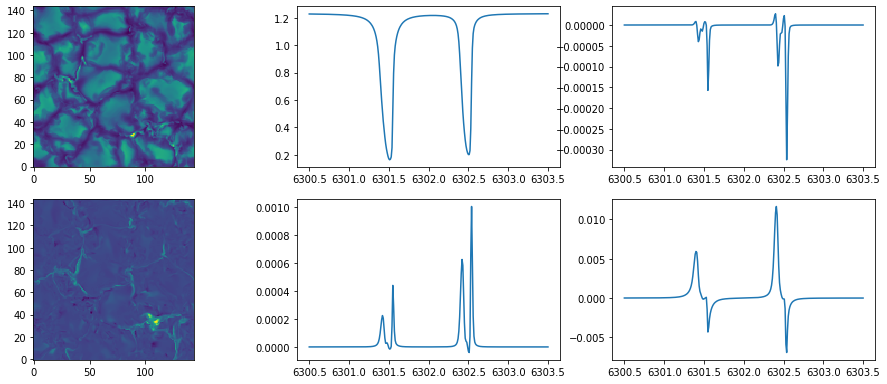

In [5]:
# Let's plot one example Stokes profile
i=100
j=100
plt.figure(figsize=[16,6.5])
plt.subplot(231)
plt.imshow(stokes[:,:,0,0],origin='Lower')
plt.subplot(234)
plt.imshow(stokes[:,:,3,30],origin='Lower')
plt.subplot(232)
plt.plot(ll,stokes[i,j,0])
plt.subplot(233)
plt.plot(ll,stokes[i,j,1])
plt.subplot(235)
plt.plot(ll,stokes[i,j,2])
plt.subplot(236)
plt.plot(ll,stokes[i,j,3])

### Ok what do you see here? Can someone comment on the shapes of the lines and the magnitudes of Stokes parameters? What do you think?

In [6]:
# Now we are going to try to invert that one spectra. 
# Inverting is fitting with M-E model.
# Let's try one line at the time. 

# What are the problems with inverting both lines simultaneously, can you discuss?
# We define wavelength regions. We will soon see what None refers to ;)

# We are inverting only the first one
ll = ll[:150]
regions = [[ll, None]]

# These are the lines
lines   = [6301]
# so now our code has wavelength grid and knows what to do

me = MilneEddington.MilneEddington(regions, lines, nthreads=1)

In [7]:
# We learned yesterday that we need an estimate of the error uncertanties, we need to specify the noise
noise_level = 1.e-3
noise = np.zeros((4, me.get_wavelength_array().size), dtype='float64', order='c')
noise += noise_level
noise[0] *= 10. #noise is typicaly larger for I, because of systematics - Discuss!

In [8]:
# We are going to get used to deal with number of pixels, so here are some new variables for you :)
nx = 1
ny = 1
model_guess = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])

# This creates nx x ny clones of model_guess
models_guess  = me.repeat_model(model_guess, nx, ny)

# What are we fitting, one Stokes profile, but remember the form it has to go in (nx x ny x 4 x n_lambda)
to_fit = stokes[i,j,:,:150].reshape(1,1,4,150)
    
#
# This is where the inversion happens:
#
model_out, syn_out, chi2 = me.invert(models_guess, to_fit, noise, nRandom = 20, nIter=100, chi2_thres=1.0, verbose=False)


In [9]:
# Let's, for the sanity's sake, print out the quantities:
print ('Model parameters :', model_out)
print ('Chi-squared = ',chi2)

Model parameters : [[[ 3.61711289e+01  1.27590668e+00  8.88620978e-01 -8.72464141e-01
    3.51972914e-02  4.66852448e+01  8.82012557e-02  1.91720563e-01
    1.03578074e+00]]]
Chi-squared =  [[2.73635257]]


$\chi^2$ is around 1, which is a good sign, the best way to see the fit, is to plot!

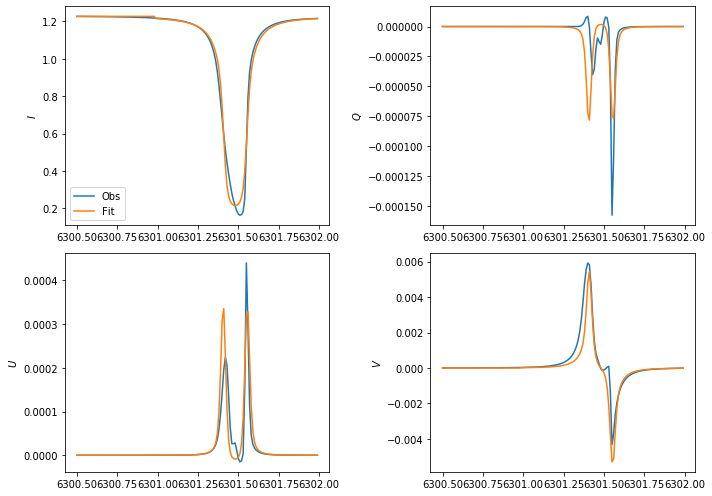

In [10]:
#test the plot
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,to_fit[0,0,0],label='Obs')
plt.plot(ll,syn_out[0,0,0],label='Fit')
plt.ylabel("$I$")
plt.legend()
plt.subplot(222)
plt.plot(ll,to_fit[0,0,1],label='Obs')
plt.plot(ll,syn_out[0,0,1],label='Fit')
plt.ylabel("$Q$")
plt.subplot(223)
plt.plot(ll,to_fit[0,0,2],label='Obs')
plt.plot(ll,syn_out[0,0,2],label='Fit')
plt.ylabel("$U$")
plt.subplot(224)
plt.plot(ll,to_fit[0,0,3],label='Obs')
plt.plot(ll,syn_out[0,0,3],label='Fit')
plt.ylabel("$V$")
plt.tight_layout()

#### Looks good! 

Now, spend some time fitting individual pixels and looking what happens there!


After you are dont with that, we can move on and fit a part of field of view (or the whole one, if you have a nice pc)

In [11]:
# First part is to make use of the parallel capabilities of modern processors and do this with
# multiple threads
me = MilneEddington.MilneEddington(regions, lines, nthreads=8)

pyMilne::dealloc: cleaning-up...


In [12]:
%%time 
# This will tell us how much time we use

# Now we are going to select a region:
i = 0 # we start from here
j = 0 
nx = 144 # and take this big chunk
ny = 144

# The same as before
model_guess = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
# Now we have 200 x 200 clones. In principle they don't have to be the same! 
models_guess  = me.repeat_model(model_guess, nx, ny)

# Select a Stokes subset to fit:
to_fit = stokes[i:i+nx,j:j+ny,:,:150].reshape(nx,ny,4,150)

# This is where the inversion happens, be mindful it will take some time
#
model_out, syn_out, chi2 = me.invert(models_guess, to_fit, noise, nRandom = 10, nIter=25, chi2_thres=1.0, verbose=False)

CPU times: user 4min 21s, sys: 228 ms, total: 4min 21s
Wall time: 33.2 s


In [13]:
print(model_out.shape)
print(chi2.shape)
#model_out = model_out.reshape(nx,ny,9)

(144, 144, 9)
(144, 144)


Well well well, look at that. Our parameters are also a cube now. And we even have a separate $\chi^2$ for each pixel! Looks great. Let's start by plotting $\chi^2$ map:

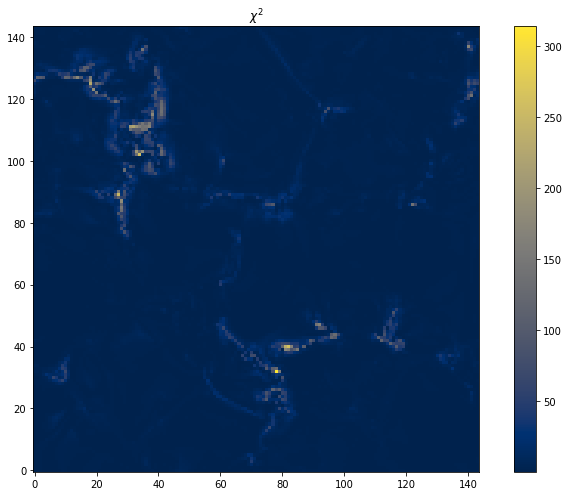

In [14]:
plt.figure(figsize=[10,7])
plt.imshow(chi2.T,cmap='cividis',origin='lower')
plt.title("$\chi^2$")
plt.colorbar()
plt.tight_layout()

Now, let's plot some parameter maps:

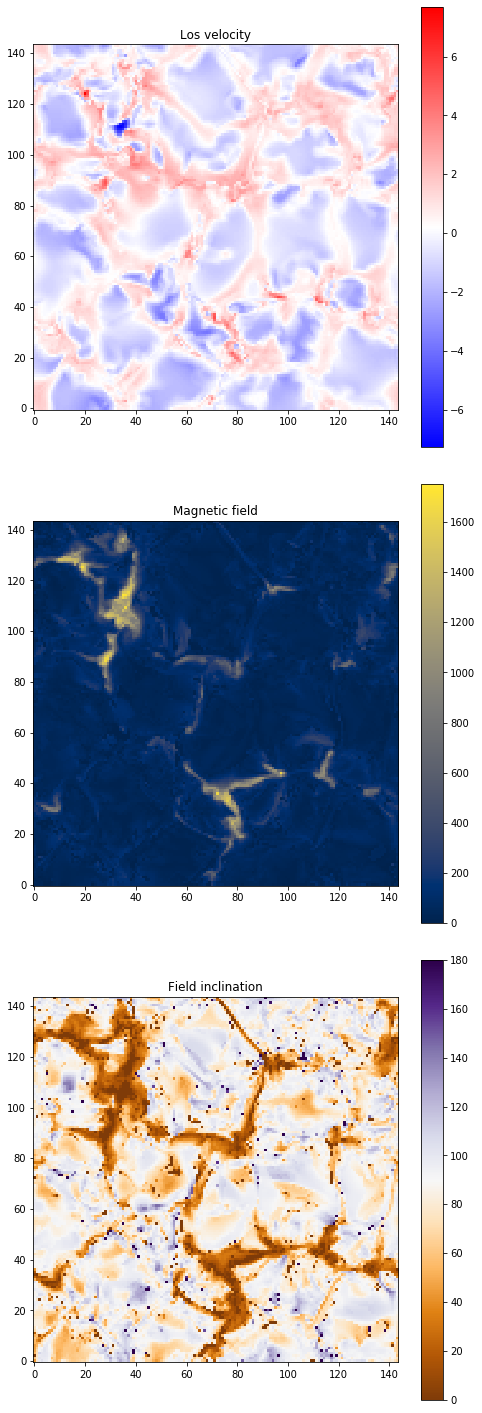

In [15]:
# The easiest sanity check for this is the velocity:
# Velocity is often normalized w.r.t the mean value 
plt.figure(figsize=[7,20])
plt.subplot(311)
plt.imshow(model_out[:,:,3].T,cmap='bwr',origin='lower')
plt.title("Los velocity")
plt.colorbar()
plt.subplot(312)
plt.imshow(model_out[:,:,0].T,cmap='cividis',origin='lower')
plt.title("Magnetic field")
plt.colorbar()
plt.subplot(313)
plt.imshow(model_out[:,:,1].T*180./np.pi,cmap='PuOr',origin='lower')
plt.title("Field inclination")
plt.colorbar()
plt.tight_layout()

### Compare with the original! 

Contrary to the fitting of the observed data, fitting synthetic data is interesting because it gives us ground truth. Let's discuss this a bit...

In [17]:
# Load the atmosphere
atmos = fits.open("/home/milic/scratch/simulated_atmos.fits")[0].data
atmos.shape

(12, 144, 144, 31)

In [27]:
print (atmos[0,0,0])

[-5.  -4.8 -4.6 -4.4 -4.2 -4.  -3.8 -3.6 -3.4 -3.2 -3.  -2.8 -2.6 -2.4
 -2.2 -2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4
  0.6  0.8  1. ]


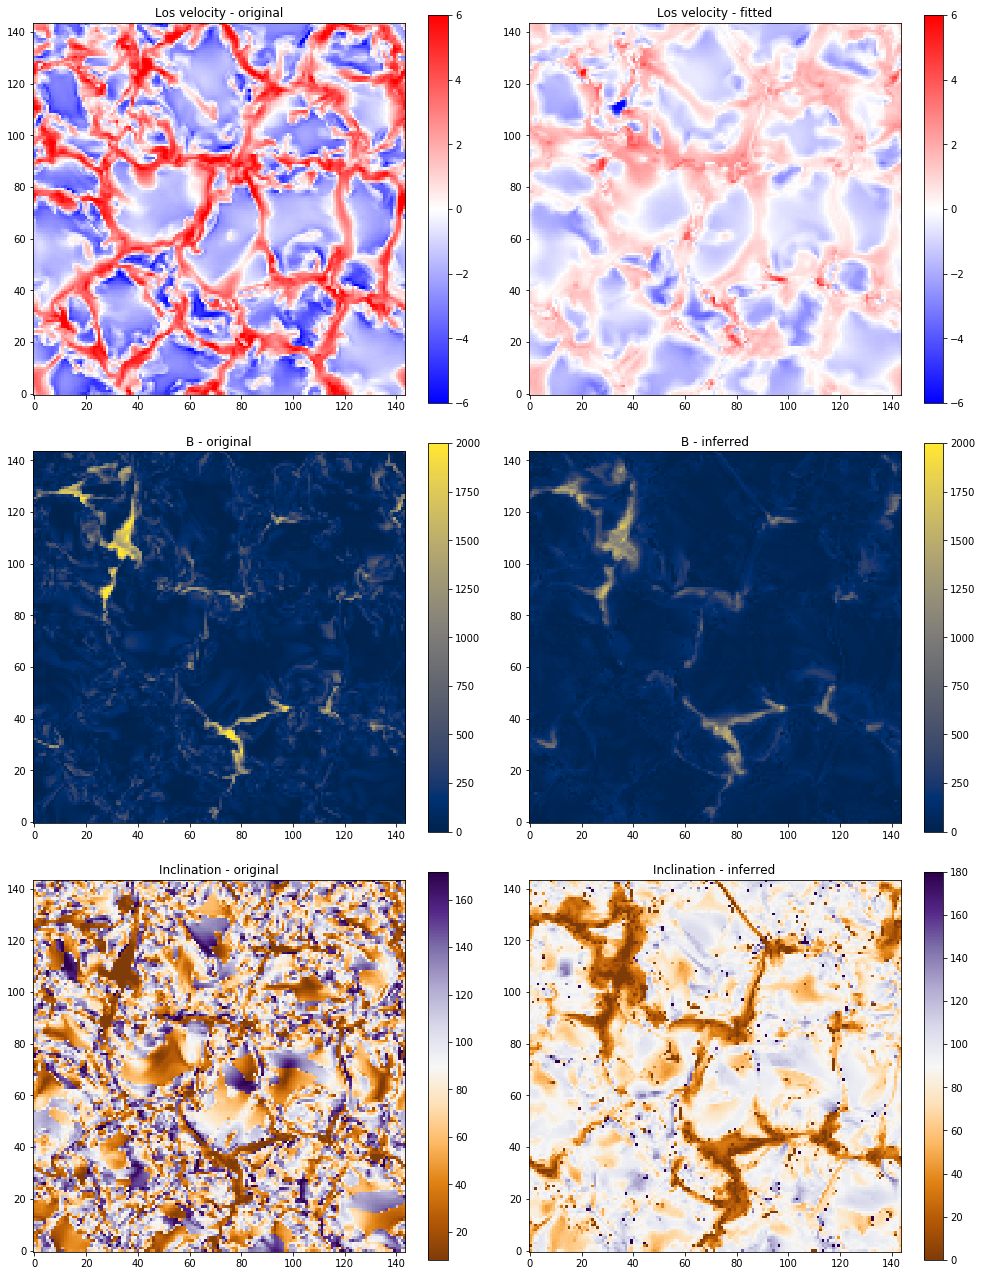

In [29]:
depth = 25

plt.figure(figsize=[14,18])
plt.subplot(321)
plt.imshow(atmos[9,:,:,depth].T/(-1E5),cmap='bwr',origin='lower',vmin=-6,vmax=6)
plt.colorbar()
plt.title("Los velocity - original")
plt.subplot(322)
plt.imshow(model_out[:,:,3].T,cmap='bwr',origin='lower',vmin=-6,vmax=6)
plt.title("Los velocity - fitted")
plt.colorbar()

plt.subplot(323)
plt.imshow(atmos[7,:,:,depth].T,cmap='cividis',origin='lower',vmin=0,vmax=2000)
plt.colorbar()
plt.title("B - original")

plt.subplot(324)
plt.imshow(model_out[:,:,0].T,cmap='cividis',origin='lower',vmin=0,vmax=2000)
plt.title("B - inferred")
plt.colorbar()


plt.subplot(325)
plt.imshow(atmos[10,:,:,depth].T*180./np.pi,cmap='PuOr',origin='lower')
plt.colorbar()
plt.title("Inclination - original")
plt.subplot(326)
plt.imshow(model_out[:,:,1].T*180./np.pi,cmap='PuOr',origin='lower')
plt.title("Inclination - inferred")
plt.colorbar()
plt.tight_layout()